# Machine Learning: Final Project
### By: Thomas Cusick, Rebecca Vanni, Avalon Bennett

## **Question**: How can the features of a home be utilized to accurately predict its sale price?

In this study, we utilize the Pierce County House Sales dataset, which contains records of home sales in Pierce County during 2020. Located just outside of Seattle, Pierce County is an affluent area known for its vibrant urban center, Tacoma, which offers a range of cultural amenities including museums, theaters, and parks. Adjacent to Mount Rainier, the county is also celebrated for its natural beauty. In late 2020, Pierce County experienced a surge in demand for housing. Our analysis seeks to model how this increased demand influenced home prices and to identify which property features were particularly sought after during this period.

Sources:
- https://movetotacoma.com/moving-to-pierce-county-wa-what-you-need-to-know/
- https://www.redfin.com/county/3096/WA/Pierce-County/housing-market
- https://www.windermerepugetsound.com/blog/entry/how-coronavirus-is-affecting-the-pierce-county-real-estate-market



**Model**: For our modeling approach, we selected a **Regression Decision Tree**. This method is well-suited for our analysis because the target variable, sale price, is continuous. Regression Decision Trees evaluate each feature independently, effectively capturing non-linear relationships between individual features and the target variable. Additionally, they can accommodate both numerical and categorical inputs, making them highly flexible to the different features our dataset included. In this case, sale price served as our target variable, while the various attributes of each house were used as predictive features.  

Reading Data and Importing Packages

In [24]:
!pip install graphviz

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from scipy import stats
from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.metrics import mean_squared_error, r2_score

house_sales = pd.read_csv('/content/pierce_county_house_sales.csv')

### Clean the Data:
To clean the data for the model, we needed to ensure that the data types were categorical, int, or float. That way the model could properly interpret, analyze, and compare the data within each feature. Along with that, we had to decide which columns were worth keeping; too many niche or minimally contirubuting features would overfit our model to this specific dataset.

To clean the data, we...

1.   Dropped the view quality column because it had a low correlation and the values of it were to specific to be used in a categorical way. It would have overcomplicated the model.
2. Converted the sale date column to be a datetime type so that it could be interpreted by the model. We also added a month column so that we could observe broader patterns over the year.
3. Turned the HVAC column into categorical, so it could be used in the Decision Tree.
4. Turned the exterior (what the house is made of) into categorical and chose the four most popular materials. After that, every additional exterior type was classified as other to make sure once again that the model didn't contain to many features.
5. Turned the exterior, interior, sewer, and roof_cover into categorical from object so can be used in the model (eventually will make dummies).
6. Similiar to exterior, we seperated waterfront into objects, then filled all the nan values with 'not on waterfront', and changed the variable to categorical.
7. Dropped rows that contain nan values, which by this point were few when we tested to see, so the data set could now function more smoothly with them removed.



In [26]:
## Dropping unnecessary column (hard to work with)
house_sales = house_sales.drop(columns=['view_quality'])

# Convert 'sale_date' to datetime
house_sales['sale_date'] = pd.to_datetime(house_sales['sale_date'])

#adding a month category
house_sales['sale_month'] = house_sales['sale_date'].dt.month

# Categorical conversions
house_sales['hvac_description'] = house_sales['hvac_description'].astype('category')


# Simplify 'exterior' categories
house_sales['exterior'] = house_sales['exterior'].apply(
    lambda x: x if x in ["Frame Siding", "Frame Vinyl", "Masonry Common Brick", "Frame Stucco"] else "Other"
)

#changing into categorical
house_sales['exterior'] = house_sales['exterior'].astype('category')
house_sales['utility_sewer'] = house_sales['utility_sewer'].astype('category')
house_sales['interior'] = house_sales['interior'].astype('category')
house_sales['roof_cover'] = house_sales['roof_cover'].astype('category')

# Handle 'waterfront_type'
house_sales['waterfront_type'] = house_sales['waterfront_type'].astype(object)
house_sales['waterfront_type'] = house_sales['waterfront_type'].fillna('Not on waterfront')
house_sales['waterfront_type'] = house_sales['waterfront_type'].astype('category')

#dropping na
house_sales = house_sales.dropna()

# Preview data
house_sales.head()

,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,utility_sewer,sale_month
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,Not on waterfront,SEWER/SEPTIC INSTALLED,1
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,Not on waterfront,SEWER/SEPTIC INSTALLED,1
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,Not on waterfront,SEWER/SEPTIC INSTALLED,1
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,Not on waterfront,SEWER/SEPTIC INSTALLED,1
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,Not on waterfront,SEWER/SEPTIC INSTALLED,1


## Exploratory Data Analysis


### Checking Cleaning and Summary Stats

We first checked for missing values in the data set after cleaning to ensure the model can run without errors. After running this statement, it is clean and we can begin with our analysis.

In [27]:
# Ensuring no missing values
print("Missing Values:\n", house_sales.isnull().sum())
#looks all good.

Missing Values:
 sale_date                      0
sale_price                     0
house_square_feet              0
attic_finished_square_feet     0
basement_square_feet           0
attached_garage_square_feet    0
detached_garage_square_feet    0
fireplaces                     0
hvac_description               0
exterior                       0
interior                       0
stories                        0
roof_cover                     0
year_built                     0
bedrooms                       0
bathrooms                      0
waterfront_type                0
utility_sewer                  0
sale_month                     0
dtype: int64


Looking at the summary statistics of the features in the house sales data set, count shows the amount of data points in total, which is 16797 points that will be put into out model. It also shows the mean, min, and std. Based on this information, we removed outliers which were determined by IQR.

In [28]:
print("\nSummary Statistics:\n", house_sales.describe())


Summary Statistics:
                            sale_date    sale_price  house_square_feet  \
count                          16797  1.679700e+04       16797.000000   
mean   2020-07-16 14:02:33.027326464  4.609776e+05        1880.764363   
min              2020-01-01 00:00:00  2.000000e+03           1.000000   
25%              2020-04-27 00:00:00  3.480000e+05        1320.000000   
50%              2020-07-27 00:00:00  4.163430e+05        1774.000000   
75%              2020-10-09 00:00:00  5.235450e+05        2352.000000   
max              2020-12-31 00:00:00  6.130000e+06        9510.000000   
std                              NaN  2.342215e+05         759.762716   

       attic_finished_square_feet  basement_square_feet  \
count                16797.000000          16797.000000   
mean                    24.902364            167.925641   
min                      0.000000              0.000000   
25%                      0.000000              0.000000   
50%                      

### Histogram of Sale Price

**Histogram before outlier removal:**

To begin, we examined the distribution of the sale price in order to better understand our target variable and determine whether outliers would need to be removed. The histogram revealed that the distribution is right-skewed, indicating the presence of a significant number of high-end outliers. These extreme values could negatively impact the model’s effectiveness by skewing predictions and reducing overall predictive accuracy. As a result, addressing outliers will be an important step before model development.

**Histogram after outlier removal:**

To improve the model’s predictive performance, we removed outliers from the sale price variable using the interquartile range (IQR) method. We first calculated the first quartile (Q1) and third quartile (Q3) of sale prices, then computed the IQR as the difference between Q3 and Q1. Any observations with sale prices below 1.5 times the Q1 values and any above 1.5 Q3 were considered outliers and removed from the dataset. This step was necessary to reduce the influence of extreme values, which could otherwise distort the model's predictions. After removing the outliers, we visualized the updated sale price distribution, which appeared more symmetrical and better suited for modeling.

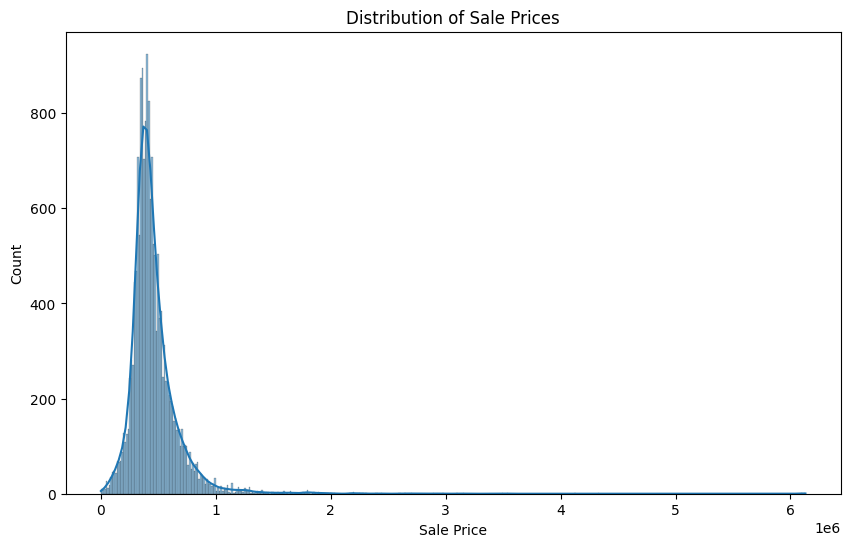

In [29]:
# Visualize Sale Price Distribution
plt.figure(figsize=(10,6))
sns.histplot(house_sales['sale_price'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.show()

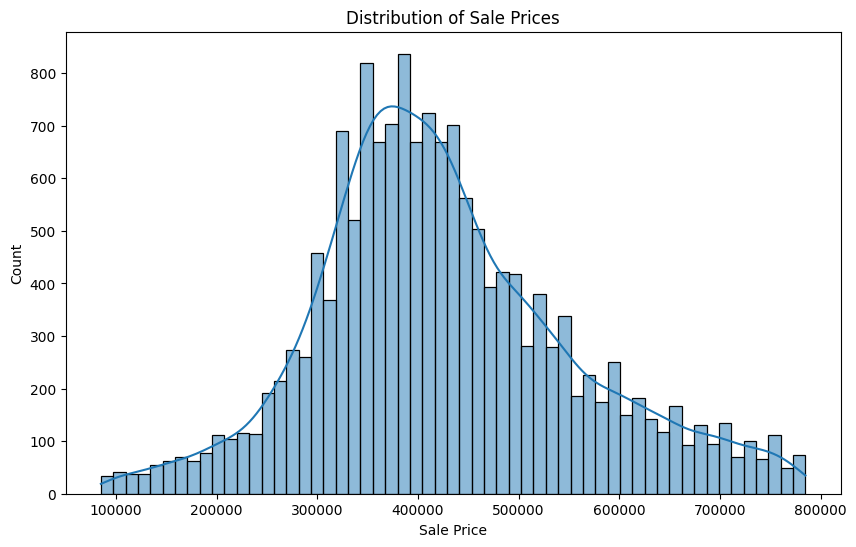

In [30]:
#remove the outliers sale price so model is better able to predict
Q1 = house_sales['sale_price'].quantile(0.25)
Q3 = house_sales['sale_price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

house_sales = house_sales[(house_sales['sale_price'] >= lower_bound) & (house_sales['sale_price'] <= upper_bound)]
# Visualize Sale Price Distribution
plt.figure(figsize=(10,6))
sns.histplot(house_sales['sale_price'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.show()

### Correlation Matrix

Now we are going to use a correlation matrix to assess which variables are most related to the sale price. This will better allow us to find relationships and create graphs that will hopefully explain how the model will function.

From the matrix, we see a strong correlation between the house square feet, garage square feet, and bathrooms. All of which could be important for the models functioning later on.

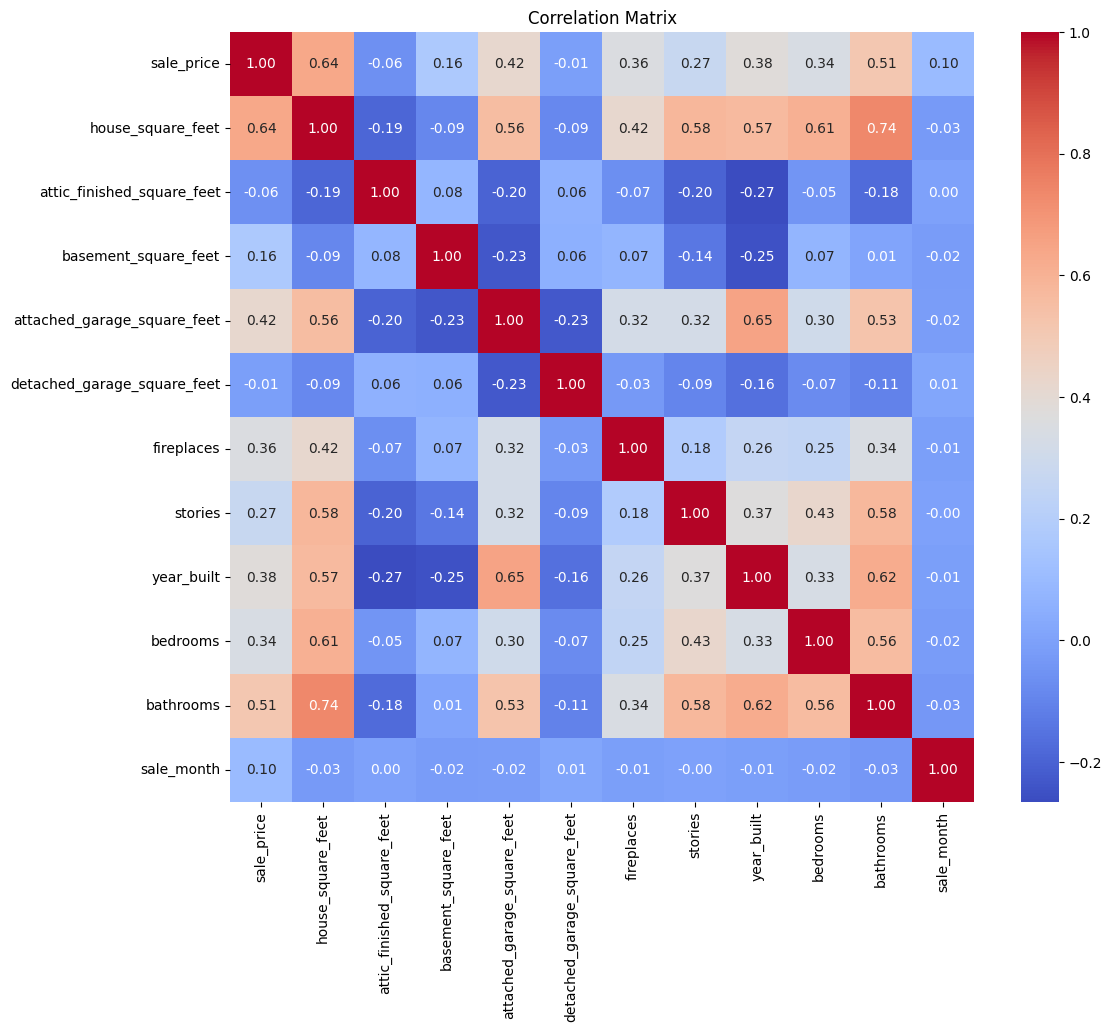

In [31]:
# Correlation Matrix
plt.figure(figsize=(12,10))
sns.heatmap(house_sales.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Sale Price vs Square Feet of House

This scatter plot visualizes the relationship between a home's sale price and its square footage. We observe a general upward trend, indicating that larger houses tend to sell for higher prices. However, the relationship is not perfectly linear — there is considerable spread at every sale price level. In particular, for any given sale price, there is wide variation in the size of houses sold, suggesting that while square footage is an important factor in determining sale price, it is not the only factor. Also, there are several outliers indicating that other features or prices weren't correctly placed.

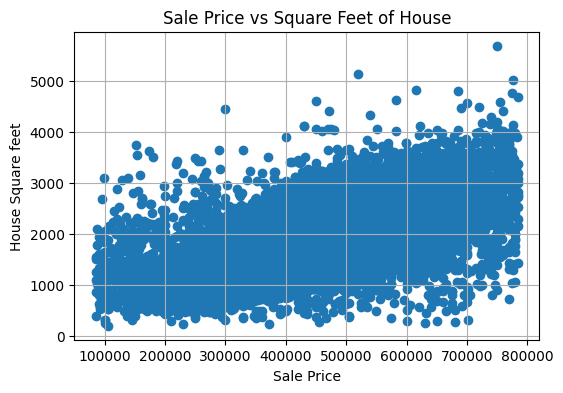

In [32]:
#Creating Graph of House Square feet and also bathrooms against the sale price
plt.figure(figsize=(6, 4))
plt.scatter(house_sales['sale_price'], house_sales['house_square_feet'])
plt.xlabel('Sale Price')
plt.ylabel('House Square feet')
plt.title('Sale Price vs Square Feet of House')
plt.grid(True)
plt.show()

### Bathrooms and the Average Sale Price
This bar graph shows the relationship between the number of bathrooms and the average sale price of homes. We binned the bathrooms at whole numbers and then averaged the sale price at those bins. As the numbers of bathrooms increases, so does the sale price. Until bathrooms reach 5 where there is slight decrease in sale price, indicating a diminishing return in amount of bathrooms. While 8 bathrooms increases values, this could be because 8 bathrooms is rare and is influenced by a few outliers, indicating people demmand four bathrooms most often.

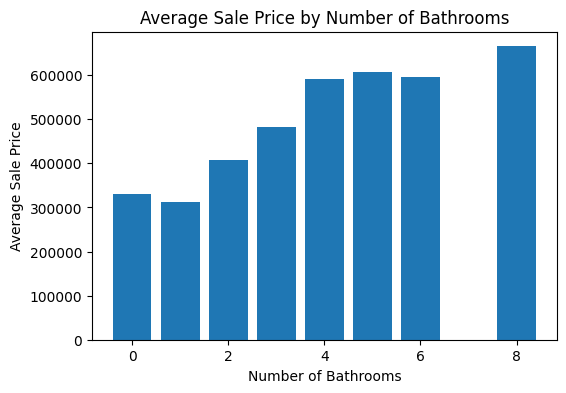

In [33]:
bathroom_means = house_sales.groupby('bathrooms')['sale_price'].mean()
plt.figure(figsize=(6, 4))
plt.bar(bathroom_means.index, bathroom_means.values)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price by Number of Bathrooms')
plt.grid(False)
plt.show()

### Plotting Average Prices vs Sale Date
In this graph we can see a possible limitation of the model. While dropped when calculating the decision tree, the date has a pretty large relationship with sale price. The model doesn't understand the nuances of COVID-19 and how it affected the housing market in 2020. The increase in sale price could be due to an increased demand as people wanted to move out of the city. The model will tell how it accounts for this.


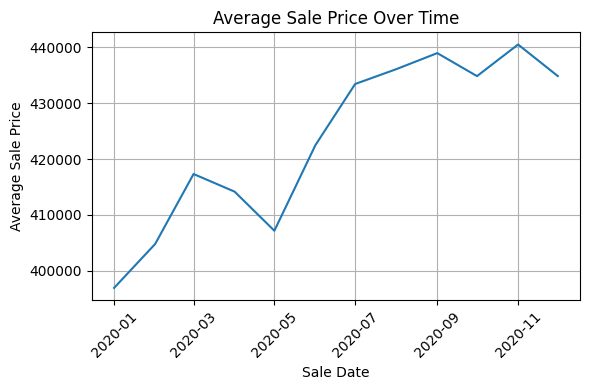

In [34]:
average_prices = house_sales.groupby(house_sales['sale_date'].dt.to_period('M'))['sale_price'].mean()
average_prices = average_prices.to_timestamp()

plt.figure(figsize=(6, 4))
plt.plot(average_prices.index, average_prices.values)
plt.xlabel('Sale Date')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Creating the Model
Techniques you are using to address your question and the results of those methods.


### Getting Dataset ready, assigning variables and dummmies, and train/test split

To predict home sale prices, we used a decision tree regression model. We defined sale_price as the target variable and applied one-hot encoding to convert categorical features into numeric form. After dropping unnecessary columns, we split the data into training and testing sets to evaluate model performance. Finally, we applied repeated k-fold cross-validation to ensure reliable and generalizable results.

In [35]:
#Define Features and Target
# Drop only existing columns: sale_price (target) and sale_date (timestamp and model cant use)
X = house_sales.drop(columns=['sale_price', 'sale_date'])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Define Target
y = house_sales['sale_price']

# STEP 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=21)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50,random_state=42)

kf = RepeatedKFold(n_splits=10,n_repeats =5, random_state=42)

#Creating our parameter list
We set up a dictionary called param that contains the parameters to test for my Decision Tree model. Here's what each parameter means:

max_depth:
The maximum depth of the decision tree. A deeper tree can capture more complexity but might overfit the training data. We will try tree depths of 3, 5, 7, 9, and 11.

splitter:
This decides how the tree chooses to split at each node.
"best" means it chooses the best split based on the data.
"random" means it picks a random split among the best options.

min_samples_leaf:
The minimum number of samples required to be at a leaf node. Setting this higher can prevent the model from learning very specific patterns (overfitting).

ccp_alpha:
Complexity parameter used for Minimal Cost-Complexity Pruning. Increasing ccp_alpha prunes more of the tree, which can help in reducing overfitting.


We evaulted the model based on three diferent scoring metrics:

neg_mean_squared_error: Negative of the mean squared error (lower MSE is better).

r2: R-squared score, which measures how well the model explains the variance in the target.

neg_mean_absolute_error: Negative of the mean absolute error (lower MAE is better).


In [36]:
param={
    "max_depth" : [3,5,7,9,11],
    "splitter":["best","random"],
    "min_samples_leaf":[1,2,4],
    'ccp_alpha':[.001,.01,.1]
        }

scoring= ['neg_mean_squared_error','r2','neg_mean_absolute_error']

### Creating the model and a visual

We used a grid search with cross-validation to tune the decision tree regressor. The model was trained and evaluated across different max_depth values, using R² as the primary metric for selecting the best model. Grid search helped systematically identify the tree that achieved the strongest predictive performance.

The visual shows the decision tree that the model created. A max depth of six is a pretty good depth for the first model we created.

In [37]:
reg=DecisionTreeRegressor(random_state=42)
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')

model = search.fit(X_train, y_train)
best = model.best_estimator_
print(best)

DecisionTreeRegressor(ccp_alpha=0.001, max_depth=7, min_samples_leaf=4,
                      random_state=42)


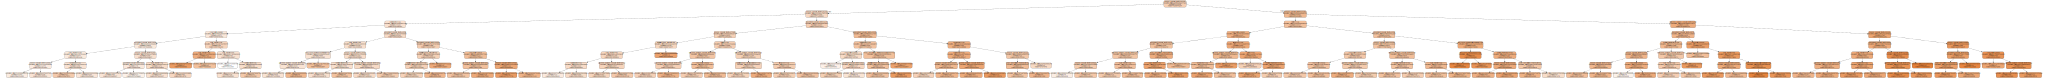

In [38]:
dot_data = export_graphviz(best, out_file =None,feature_names =X_train.columns,filled=True,rounded=True, )

graph = graphviz.Source(dot_data)
graph

This is the detailed tree for inspection.

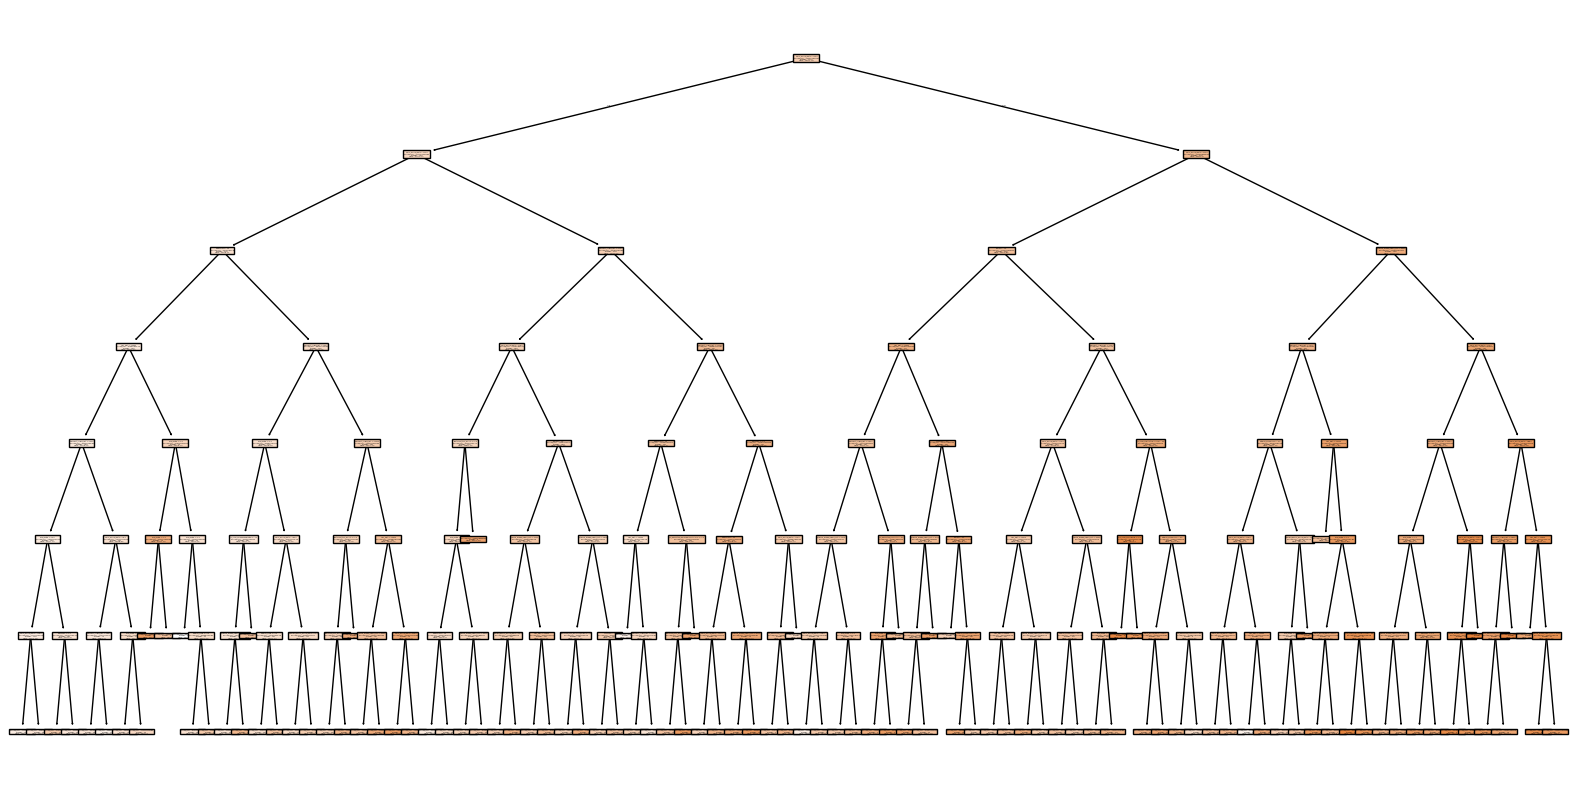

In [39]:
plt.figure(figsize=(20, 10))
plot_tree(best, feature_names=X_train.columns, filled=True)
plt.show()

This is the far out tree for a visual of how it worked.

### Varaible Importance

After training the model, we calculated feature importance scores to identify which variables most strongly influenced sale price predictions. We visualized the top 15 features using a bar plot, highlighting the attributes that had the greatest impact on the model’s decisions.

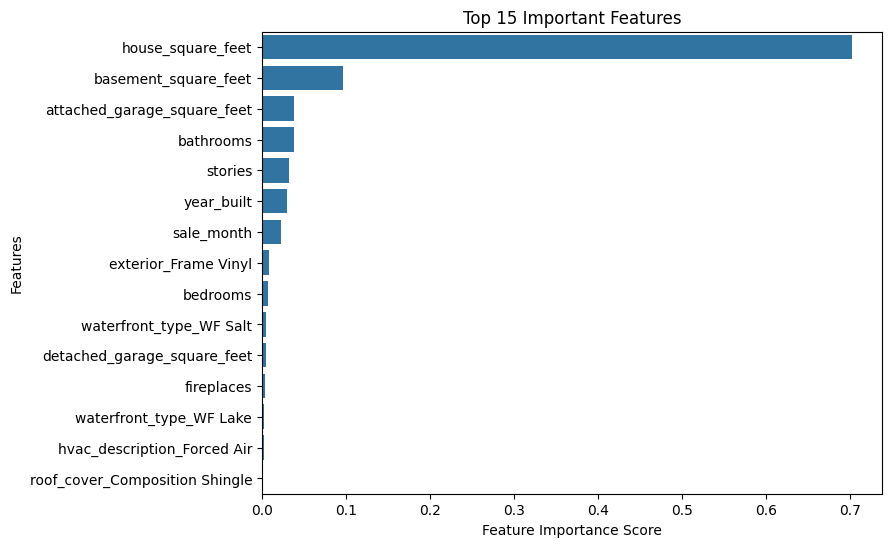

In [40]:
varimp = pd.DataFrame(best.feature_importances_,index=X.columns,columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=varimp['importance'].head(15), y=varimp.index[:15])  # <- Only use the 'importance' column for x
plt.title('Top 15 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

Creating a model that only uses the top 4 important features
Select the top 4 most important features based on the variable importance ranking.
Create a new tuning dataset (X_tune_top4) containing only these top 4 features, and use the same target (y_tune_top4).
Perform a grid search using the previously defined search object, but fit it on this reduced set of features.
Retrieve and print the best model (best4) found during the grid search.

In [41]:
top4_features = varimp.head(4).index.tolist()
X_tune_top4 = X_tune[top4_features]
y_tune_top4 = y_tune

top4_model = search.fit(X_tune_top4, y_tune)
best4 = top4_model.best_estimator_
print(best4)

DecisionTreeRegressor(ccp_alpha=0.001, max_depth=5, min_samples_leaf=4,
                      random_state=42)


### Evaluate Model
Select appropriate metrics
- R2
- RMSE
- Decision Tree

Explain the output as it relates to your question.
- Sale_price
- Predict the highest selling houses and compare


To evaluate our regression model, we selected R² and RMSE because each of these metrics provides us insights into our model's performance:

R²:
This coefficient of determination measures the proportion of variance in the target (in this case, sale price) that is predictable from the features. It provides a sense of how much of the real-world variability our model captures. In real estate evaluation, understanding what fraction of price variation is explained matters to all parties involved.

RMSE:
This is the square root of MSE, converting the unit of measurement back to dollars (which is the same unit as sale prices). RMSE translates prediction error into terms that are easily interpretable by stakeholders.

Using both of these metrics together allows us to both evaluate model goodness-of-fit (with R²) and quantify practical prediction error (with RMSE). This ensures that our model is not just statistically strong but also economically meaningful for real-world stakeholders in housing markets.

In [42]:
y_train_pred = best.predict(X_train)

r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"RMean Squared Error: {rmse_train:.2f}")
print(f"R2 Score: {r2_train:.2f}")

RMean Squared Error: 83683.58
R2 Score: 0.58


In [43]:
y_tune_pred = top4_model.predict(X_tune_top4)
r2 = r2_score(y_tune, y_tune_pred)
rmse = np.sqrt(mean_squared_error(y_tune, y_tune_pred))

print("Top 4 Features Used:", top4_features)
print(f"Tune R² Score (Top 7 Model): {r2:.4f}")
print(f"Tune RMSE (Top 7 Model): {rmse:.2f}")

Top 4 Features Used: ['house_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'bathrooms']
Tune R² Score (Top 7 Model): 0.5111
Tune RMSE (Top 7 Model): 90340.05


In [44]:
model = search.fit(X_test, y_test)
best= model.best_estimator_
print(best)

y_test_pred = best.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMean Squared Error: {rmse_test:.2f}")
print(f"R2 Score: {r2_test:.2f}")

DecisionTreeRegressor(ccp_alpha=0.001, max_depth=5, min_samples_leaf=4,
                      random_state=42)
RMean Squared Error: 88779.23
R2 Score: 0.52


### Conclusions
What can you say about the results of the methods section as it relates to your question given the limitations to your model.


In [45]:
results_table = pd.DataFrame({
    'Train (Model 1)': [rmse_train, r2_train],
    'Tune (Model 2)': [rmse, r2],
    'Test (Best Model)': [rmse_test, r2_test]
}, index=['RMSE', 'R²'])

results_table

,Train (Model 1),Tune (Model 2),Test (Best Model)
RMSE,83683.582031,90340.054829,88779.232797
R²,0.580644,0.511104,0.523080


Training Set (Model 1): The model explained 58.06% of the variance in sale prices with an average prediction error of around $83,684.  

This suggests a reasonable but not perfect fit to the training data, avoiding severe overfitting.

Tune Set (Model 2): On the tune set, performance slightly dropped, with 51.11% of variance explained and RMSE rising to $90,340.

This slight decline is expected and indicates that the model maintains generalization rather than memorizing training data.

Test Set (Best Model): After selecting the best model, we achieved an R² of 52.31% and an RMSE of $88,779 on unseen data.

This shows our model can reliably predict home prices within a margin of about $88,779 on average — a realistic and valuable result given the high variability of real estate pricing.


While the model does not achieve extremely high R² (closer to 1.0), it still explains over half of the variability in sale prices.
Given the natural unpredictability in home sales — driven by factors like location preferences, market psychology, and external economic shifts — an R² around 0.52 is solid for this context.
The relatively stable RMSE across train, tune, and test sets suggests the model is well-regularized and not overfitting.

These metrics reinforce the decision to use a Regression Decision Tree: it captures complex relationships between home features and sale price while still generalizing well to new data. Our evaluation strategy, combining R², MSE, and RMSE, allows both technical rigor and intuitive communication of the model's real-world effectiveness.

### Future Ideas and Analysis
Potential Model Enhancements:

Price Binning:
One avenue to explore would be binning sale prices into categories (e.g., low, medium, high) and reframing the problem as a classification task. This could simplify the modeling and potentially improve prediction performance if sale prices are difficult to predict precisely but group into natural tiers.
Feature Engineering and Inflation Adjustment:
Future models could benefit from adjusting sale prices for inflation. This would normalize housing prices across years and help isolate genuine shifts in market behavior from simple economic trends.
Additional Analysis Opportunities:

Testing Across Different Years:
To test the generalizability of our model, we could evaluate its performance on housing sales data from 2021 (post-COVID onset) or from other historically significant periods, such as:
2008 Financial Crisis — to observe market crashes.
Other pandemic years — to compare demand patterns.
Extended Temporal Analysis:
Visualize housing prices over a 5–10 year window to understand longer-term trends.
Analyze the number of houses sold per year to capture supply-side market shifts.
Create overlay plots comparing historical events (like COVID-19) against housing price trajectories and transaction volumes to better understand causality and impact.
Project Limitations:

Temporal Scope of the Data:
The dataset was restricted to 2020, a year marked by unusual market behavior due to the COVID-19 pandemic and stimulus-driven inflation. Buyer behavior in 2020 may not represent typical market conditions, limiting the broader applicability of the model.
Incomplete Economic Adjustment:
While we acknowledged price inflation and buying trends sparked by the pandemic, we did not formally incorporate macroeconomic factors (like interest rates, unemployment rates, or inflation indices) into the model. As a result, the model may misattribute some price changes solely to home features rather than broader economic shifts.
Limited Forecasting Across Years:
We primarily treated 2020 as an isolated event rather than analyzing sequential year-over-year trends. Future work could expand to model cyclical housing patterns versus long-term structural changes that began during the pandemic and persisted thereafter.
